In [9]:
# 针对真实图片生成轨迹
# 添加库函数
import os
import torch
import torch.nn as nn
import math
import torch.optim as optim
from pytorch3d.io import load_obj, save_obj
from pytorch3d.structures import Meshes
from pytorch3d.utils import ico_sphere
from pytorch3d.ops import sample_points_from_meshes
from pytorch3d.loss import (
    chamfer_distance, 
    mesh_edge_loss, 
    mesh_laplacian_smoothing, 
    mesh_normal_consistency,
)
from pytorch3d.utils import ico_sphere
import numpy as np
from tqdm.notebook import tqdm
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
import matplotlib as mpl
from pytorch3d.renderer import (
    FoVPerspectiveCameras, look_at_view_transform, look_at_rotation, 
    RasterizationSettings, MeshRenderer, MeshRasterizer, BlendParams,
    SoftSilhouetteShader, HardPhongShader, PointLights, TexturesVertex,OrthographicCameras
)
from pytorch3d.vis.plotly_vis import plot_batch_individually
from pytorch3d.ops.points_normals import estimate_pointcloud_normals
from pytorch3d.ops.mesh_face_areas_normals import mesh_face_areas_normals
from torch.autograd import gradcheck

import plotly.graph_objects as go

from PIL import Image

import re

mpl.rcParams['savefig.dpi'] = 80
mpl.rcParams['figure.dpi'] = 80

# Set the device
if torch.cuda.is_available():
    device = torch.device("cuda:3")
else:
    device = torch.device("cpu")
    print("WARNING: CPU only, this will be slow!")

In [27]:

def vec_rot(vec,axis_x,axis_y,axis_z,theta):

    axis_x = axis_x.expand(theta.shape)
    axis_y = axis_y.expand(theta.shape)
    axis_z = axis_z.expand(theta.shape)

    c = torch.cos(theta)
    s = torch.sin(theta)
    one_c = 1 - c

    Rotmat = torch.stack([
        torch.stack([axis_x**2 * one_c + c, axis_x * axis_y * one_c - axis_z * s, axis_x * axis_z * one_c + axis_y * s], dim=-1),
        torch.stack([axis_x * axis_y * one_c + axis_z * s, axis_y**2 * one_c + c, axis_y * axis_z * one_c - axis_x * s], dim=-1),
        torch.stack([axis_x * axis_z * one_c - axis_y * s, axis_y * axis_z * one_c + axis_x * s, axis_z**2 * one_c + c], dim=-1)
    ], dim=-2)

    vec_rot = torch.matmul(Rotmat,vec.unsqueeze(1)).squeeze(2)

    return vec_rot

def Radarview_generate():

    # 接下来的所有操作都在z-x-y坐标系下进行
    
    modelselect = 5
    if modelselect == 1:
        # 小行星视线方向及转轴生成
        # batchsize
        batch = 60
        # 生成多组初始雷达视线方向
        theta_losnum = 5
        theta_los = torch.linspace(-math.pi/3,math.pi/3,theta_losnum).to(device)
        radarlos_origin = torch.tensor(([0,0,-1.0]), device=device)
        omega_vec_origin = torch.tensor(([1.0,0.0,0.0]), device=device)
        RadarLos = vec_rot(radarlos_origin,omega_vec_origin[0],omega_vec_origin[1],omega_vec_origin[2],theta_los)
        # 生成多组旋转角度
        theta = torch.linspace(0,2*math.pi,batch).to(device)
        # 生成多组转轴
        omega_vec_origin1 = torch.tensor(([0.0,1.0,0.0]), device=device)
        omega_vec = vec_rot(omega_vec_origin1,omega_vec_origin[0],omega_vec_origin[1],omega_vec_origin[2],theta_los)
        # 得到雷达视线方向
        Round_radar_los_all = torch.zeros((batch*RadarLos.shape[0],3),device=device)
        Round_radar_los_real_all = torch.zeros((batch*RadarLos.shape[0],3),device=device)
        omega_vec_all = torch.zeros((batch*omega_vec.shape[0],3),device=device)
        for i,j in zip(range(RadarLos.shape[0]),range(omega_vec.shape[0])):
                Round_radar_los = vec_rot(RadarLos[i],omega_vec[j,0],omega_vec[j,1],omega_vec[j,2],-theta)
                Round_radar_los_all[batch*i:batch*(i+1)] = Round_radar_los
                Round_radar_los_real_all[batch*i:batch*(i+1)] = vec_rot(RadarLos[i],omega_vec[j,0],omega_vec[j,1],omega_vec[j,2],theta)
                print(omega_vec[j])
                omega_vec_all[batch*j:batch*(j+1)] = omega_vec[j].expand(batch,3)
        # 转速
        omega = torch.tensor([1.0],device=device).expand(Round_radar_los_all.shape[0])
    if modelselect == 2:
        # tomosar视线方向及转轴生成
        # batchsize
        batch = 40
        # 生成一组初始雷达视线方向
        RadarLos = torch.tensor(([0,0,-1.0]), device=device)
        # 生成多组旋转角度
        theta = torch.linspace(-math.pi/3,math.pi/3,batch).to(device)
        # 生成一组转轴
        omega_vec = torch.tensor(([0.0,1.0,0.0]), device=device)
        # 生成一组雷达视线旋转转轴
        rotation_vec = torch.tensor(([1.0,0.0,0.0]), device=device)
        Round_radar_los_all = vec_rot(RadarLos,rotation_vec[0],rotation_vec[1],rotation_vec[2],-theta)
        Round_radar_los_real_all = Round_radar_los_all
        omega_vec_all = omega_vec.expand(batch,3)
        # 转速
        omega = torch.tensor([1.0],device=device).expand(Round_radar_los_all.shape[0])
    if modelselect == 4:
        # 小行星视线方向及转轴生成
        # batchsize
        batch = 30
        # 生成多组初始雷达视线方向
        RadarLos = torch.tensor(([-1.0,0.0,0.0],[-math.sqrt(3)/2,0.0,1/2],[-math.sqrt(3)/2,0.0,-1/2]), device=device)
        # 生成多组旋转角度
        theta = torch.linspace(0,2*math.pi,batch).to(device)
        # 生成多组转轴
        omega_vec = torch.tensor(([0.0,0.0,1.0],[0.0,0.0,1.0],[0.0,0.0,1.0]), device=device)
        # 得到雷达视线方向
        Round_radar_los_all = torch.zeros((batch*RadarLos.shape[0],3),device=device)
        Round_radar_los_real_all = torch.zeros((batch*RadarLos.shape[0],3),device=device)
        omega_vec_all = torch.zeros((batch*omega_vec.shape[0],3),device=device)
        for i,j in zip(range(RadarLos.shape[0]),range(omega_vec.shape[0])):
                Round_radar_los = vec_rot(RadarLos[i],omega_vec[j,0],omega_vec[j,1],omega_vec[j,2],-theta)
                Round_radar_los_all[batch*i:batch*(i+1)] = Round_radar_los
                Round_radar_los_real_all[batch*i:batch*(i+1)] = vec_rot(RadarLos[i],omega_vec[j,0],omega_vec[j,1],omega_vec[j,2],theta)
                omega_vec_all[batch*j:batch*(j+1)] = omega_vec[j].expand(batch,3)
        # 转速
        omega = torch.tensor([1.0],device=device).expand(Round_radar_los_all.shape[0])
    if modelselect == 3:
        # 小行星视线方向及转轴生成
        # batchsize
        batch = 30
        # 生成多组初始雷达视线方向
        RadarLos = torch.tensor(([-1.0,0.0,0.0],[-math.sqrt(3)/2,0.0,1/2],[-math.sqrt(3)/2,0.0,-1/2]), device=device)
        # 生成多组旋转角度
        theta = torch.linspace(0,2*math.pi,batch).to(device)
        # 生成多组转轴
        omega_vec = torch.tensor(([0.0,0.0,1.0],[1/2,0,math.sqrt(3)/2],[-1/2,0.0,math.sqrt(3)/2]), device=device)
        # 得到雷达视线方向
        Round_radar_los_all = torch.zeros((batch*RadarLos.shape[0],3),device=device)
        Round_radar_los_real_all = torch.zeros((batch*RadarLos.shape[0],3),device=device)
        omega_vec_all = torch.zeros((batch*omega_vec.shape[0],3),device=device)
        for i,j in zip(range(RadarLos.shape[0]),range(omega_vec.shape[0])):
                Round_radar_los = vec_rot(RadarLos[i],omega_vec[j,0],omega_vec[j,1],omega_vec[j,2],-theta)
                Round_radar_los_all[batch*i:batch*(i+1)] = Round_radar_los
                Round_radar_los_real_all[batch*i:batch*(i+1)] = vec_rot(RadarLos[i],omega_vec[j,0],omega_vec[j,1],omega_vec[j,2],theta)
                omega_vec_all[batch*j:batch*(j+1)] = omega_vec[j].expand(batch,3)
        # 转速
        omega = torch.tensor([1.0],device=device).expand(Round_radar_los_all.shape[0])
    if modelselect == 5:
        # 真实小行星旋转轴轨迹
        # batchsi
        batch = 37
        Round_radar_los_all = torch.zeros((batch,3),device=device)
        Round_radar_los_real_all = torch.zeros((batch,3),device=device)
        for i in range(batch):
            # 雷达视线为螺旋线
            RadarLos = torch.tensor([math.sin(2*math.pi*i/batch/2),(i-batch/2)/batch/30+(math.sqrt(3)/2-1/4)*3/4+1/4,math.cos(2*math.pi*i/batch/2)], device=device)
            RadarLos = RadarLos / (torch.linalg.norm(RadarLos) + 1e-6)
            Round_radar_los_all[i] = RadarLos
            RadarLos_real = torch.tensor([-math.sin(2*math.pi*i/batch/2),(i-batch/2)/batch/30+(math.sqrt(3)/2-1/4)*3/4+1/4,math.cos(2*math.pi*i/batch/2)], device=device)
            RadarLos_real = RadarLos_real / (torch.linalg.norm(RadarLos_real) + 1e-6)
            Round_radar_los_real_all[i] = RadarLos_real
        omega_vec = torch.tensor(([0.0,1.0,0.0]), device=device)
        omega_vec_all = omega_vec.expand(batch,3)
        omega = torch.tensor([1.0],device=device).expand(Round_radar_los_all.shape[0])
    # 可视化雷达视线方向
    radar_los_numpy = Round_radar_los_all.detach().cpu().numpy()

    fig = go.Figure(data=[go.Scatter3d(
        x=radar_los_numpy[:,0], 
        y=radar_los_numpy[:,1], 
        z=radar_los_numpy[:,2], 
        mode='markers',
        marker=dict(
            size=2  # 设置点的大小
        )
    )])

    # 可视化转轴方向为一个向量，并将其添加到雷达视线方向图中
    omega_vec_numpy = omega_vec_all.detach().cpu().numpy()
    fig.add_trace(go.Scatter3d(
        x=[0, omega_vec_numpy[5,0]],
        y=[0, omega_vec_numpy[5,1]],
        z=[0, omega_vec_numpy[5,2]],
        mode='lines+markers',
        marker=dict(size=2),
        line=dict(width=2)
    ))

    # 更新布局
    fig.update_layout(scene=dict(
        xaxis_title='X label',
        yaxis_title='Y label',
        zaxis_title='Z label'
    ))

    # 显示图形
    fig.show()

    # 将图形保存为html文件
    fig.write_html("Radar_los.html")

    return Round_radar_los_all,Round_radar_los_real_all,omega_vec_all,omega

Round_radar_los_all,Round_radar_los_real_all,omega_vec_all,omega = Radarview_generate()
print(Round_radar_los_all.shape)
print(Round_radar_los_real_all.shape)
print(omega_vec_all.shape)
print(omega_vec_all)

torch.Size([37, 3])
torch.Size([37, 3])
torch.Size([37, 3])
tensor([[0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.]], device='cuda:3')


['image0.png', 'image1.png', 'image2.png', 'image3.png', 'image4.png', 'image5.png', 'image6.png', 'image7.png', 'image8.png', 'image9.png', 'image10.png', 'image11.png', 'image12.png', 'image13.png', 'image14.png', 'image15.png', 'image16.png', 'image17.png', 'image18.png', 'image19.png', 'image20.png', 'image21.png', 'image22.png', 'image23.png', 'image24.png', 'image25.png', 'image26.png', 'image27.png', 'image28.png', 'image29.png', 'image30.png', 'image31.png', 'image32.png', 'image33.png', 'image34.png', 'image35.png', 'image36.png']
(37, 105, 97)
torch.Size([37, 3])
0.9921568627450981
0.0
0.9921568627450981
0.0
0.984313725490196
0.0
0.9647058823529412
0.0
0.9764705882352941
0.0
1.0
0.0
0.9882352941176471
0.0
0.9921568627450981
0.0
0.996078431372549
0.0
0.9921568627450981
0.0
0.9921568627450981
0.0
1.0
0.0
0.996078431372549
0.0
0.996078431372549
0.0
0.9882352941176471
0.0
0.996078431372549
0.0
0.996078431372549
0.0
0.996078431372549
0.0
0.9921568627450981
0.0
1.0
0.0
0.9882352941

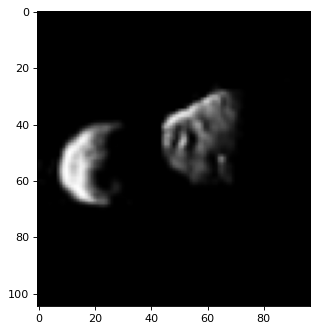

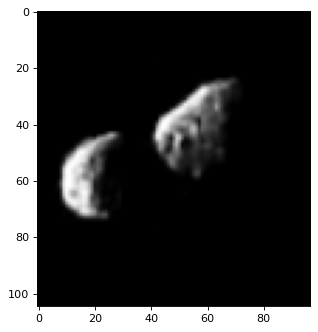

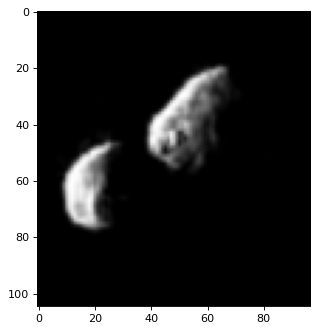

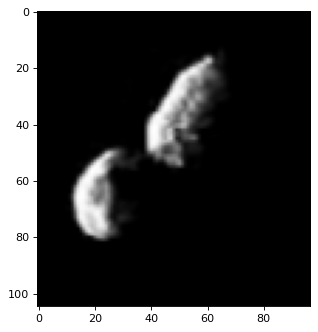

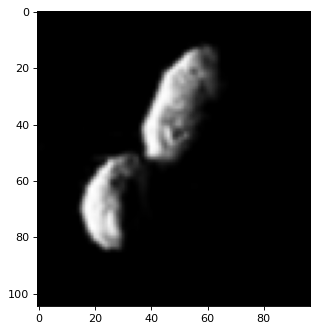

In [28]:
# 读取一个文件夹中的所有Png文件
path = 'PS_reg_resize'

def natural_sort_key(s):
    # 分割字符串中的数字并将它们转换为整数
    return [int(text) if text.isdigit() else text.lower() for text in re.split(r'(\d+)', s)]

def read_all_files(path):
    # 读取文件夹中的所有文件
    files = os.listdir(path)
    # 读取文件夹中的所有Png文件
    files = [file for file in files if file.endswith('.png')]
    # 排序文件
    files = sorted(files, key=natural_sort_key)
    # 获得png文件的长和宽
    for file in files:
        img = Image.open(os.path.join(path,file))
        length,width = img.size
        break
    return files,length,width

files,length,width = read_all_files(path)
print(files)

# 创建一个np数组
image_numpy = np.zeros((len(files),width,length))
print(image_numpy.shape)

# 读取所有的图片
for i in range(len(files)):
    img = Image.open(os.path.join(path,files[i]))
    # 转换为灰度
    img = img.convert('L')
    image_numpy[i] = np.array(img)
    img.close()



# 将image_numpy的第一维反向
image_numpy = image_numpy[::-1]

# 显示第一张图片
plt.figure()
plt.imshow(image_numpy[2],cmap='gray')
plt.figure()
plt.imshow(image_numpy[4],cmap='gray')
plt.figure()
plt.imshow(image_numpy[6],cmap='gray')
plt.figure()
plt.imshow(image_numpy[8],cmap='gray')
plt.figure()
plt.imshow(image_numpy[10],cmap='gray')



image_max = image_numpy.max()
image_min = image_numpy.min()

# 存储生成的图片
import cv2
import numpy as np
filename = './ISAR_NERF/asteroid_image_nerf_new/real_data_reg_2024On_4'
if not os.path.exists(filename):
    print("创建文件夹")
    os.makedirs(filename)
print(Round_radar_los_real_all.shape)
for i in range(0,Round_radar_los_real_all.shape[0]):
    image_i = image_numpy[i,:,:]
    image_i = (image_i - image_min)/(image_max-image_min)
    print(image_i.max())
    print(image_i.min())
    LOS_real = Round_radar_los_real_all[i].detach().cpu().numpy()
    rotation_axis = omega_vec_all[i].detach().cpu().numpy()

    np.savez(filename+'/image'+str(i)+".npz", image=image_i, LOS = LOS_real, rotation_axis = rotation_axis)
    image_i = np.uint8(image_i*255)
    cv2.imwrite(filename+'/image'+str(i)+".png",image_i)